In [19]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/sr-press


In [20]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier
import matplotlib.pyplot as plt

In [21]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.components.utils import log_model, load_model
from express.visualization import plot_action
from express.utils import add_names

In [22]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f3a4c18c970>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f3a4c18cdc0>


In [23]:
dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/sr-press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/sr-press/stores/datasets/test')


In [24]:
train_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "train"),
    xfns=["startlocation", "time", "goalscore", "defenders_in_3m_radius", "closest_3_players"], #all_features
    yfns=["concede_shots", "counterpress"], #all_labels
    load_cached=True,
    nb_prev_actions=1
)

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=["startlocation", "time", "goalscore", "defenders_in_3m_radius", "closest_3_players"], #all_features
    yfns=["concede_shots", "counterpress"], #all_labels
    load_cached=True,
    nb_prev_actions=1
)

In [25]:
train_dataset.features

start_x_a0  start_y_a0  period_id_a0  time_seconds_a0  \
game_id action_id                                                          
3788741 3             41.7375      61.285             1            6.751   
        19            84.5250      59.500             1           37.956   
        27            27.2125      13.940             1           58.802   
        31            75.7750      60.690             1           60.203   
        35            79.9750      58.055             1           61.426   
...                       ...         ...           ...              ...   
3943043 2283          82.0750      20.230             2         2708.273   
        2286          34.3000      61.710             2         2727.904   
        2302          47.7750      31.790             2         2834.844   
        2304          49.6125      35.700             2         2835.236   
        2309           8.6625      64.260             2         2866.263   

                   time_seconds_overall_a0  goalscore_team  \
game_id action_id                                            
3788741 3                            6.751               0   
        19                          37.956               0   
        27                          58.802               0   
        31                          60.203               0   
        35                          61.426               0   
...                                    ...             ...   
3943043 2283                      5408.273               2   
        2286                      5427.904               1   
        2302                      5534.844               2   
        2304                      5535.236               2   
        2309                      5566.263               2   

                   goalscore_opponent  goalscore_diff  \
game_id action_id                                       
3788741 3                           0               0   
        19                          0               0   
        27                          0               0   
        31                          0               0   
        35                          0               0   
...                               ...             ...   
3943043 2283                        1               1   
        2286                        2              -1   
        2302                        1               1   
        2304                        1               1   
        2309                        1               1   

                   nb_defenders_start_3m_a0  nb_defenders_end_3m_a0  ...  \
game_id action_id                                                    ...   
3788741 3                                 1                       1  ...   
        19                                1                       1  ...   
        27                                2                       2  ...   
        31                                1                       1  ...   
        35                                1                       1  ...   
...                                     ...                     ...  ...   
3943043 2283                              0                       0  ...   
        2286                              1                       1  ...   
        2302                              1                       1  ...   
        2304                              1                       1  ...   
        2309                              0                       0  ...   

                   teammate_3_distance_a0  opponent_1_x_a0  opponent_1_y_a0  \
game_id action_id                                                             
3788741 3                              22               42               61   
        19                             25               86               57   
        27                              6               27               11   
        31                             10               74               62   
        35        

In [26]:
for xfn in train_dataset.xfns.items():
    print(xfn)

(<function startlocation at 0x7f3a4f7a5040>, ['start_x_a0', 'start_y_a0'])
(<function time at 0x7f3a4f7b5ee0>, ['period_id_a0', 'time_seconds_a0', 'time_seconds_overall_a0'])
(<function goalscore at 0x7f3a4f7a5700>, ['goalscore_team', 'goalscore_opponent', 'goalscore_diff'])
(<function simple.<locals>._wrapper at 0x7f3a4f7a44c0>, ['nb_defenders_start_3m_a0', 'nb_defenders_end_3m_a0'])
(<function simple.<locals>._wrapper at 0x7f3a4f7a4550>, ['teammate_1_x_a0', 'teammate_1_y_a0', 'teammate_1_distance_a0', 'teammate_2_x_a0', 'teammate_2_y_a0', 'teammate_2_distance_a0', 'teammate_3_x_a0', 'teammate_3_y_a0', 'teammate_3_distance_a0', 'opponent_1_x_a0', 'opponent_1_y_a0', 'opponent_1_distance_a0', 'opponent_2_x_a0', 'opponent_2_y_a0', 'opponent_2_distance_a0', 'opponent_3_x_a0', 'opponent_3_y_a0', 'opponent_3_distance_a0'])


In [27]:
features = {
    'startlocation': [
        'start_x_a0',
        'start_y_a0'
    ],
    # 'endlocation': [
    #     'end_x_a0',
    #     'end_y_a0'
    # ],
    # 'movement': [
    #     'dx_a0',
    #     'dy_a0',
    #     'movement_a0'
    # ],
    'time': [
        'time_seconds_a0'
    ],
    'goalscore': [
        'goalscore_diff'
    ],
    # 'nb_opp_in_path': [
    #     'nb_opp_in_path_a0'
    # ],
    # 'packing_rate': [
    #     'packing_rate_a0'
    # ],
    'defenders_in_3m_radius': [
        'nb_defenders_start_3m_a0',
        # 'nb_defenders_end_3m_a0'
    ],
    # 'dist_opponent': [
    #     'dist_defender_start_a0',
    #     # 'dist_defender_end_a0',
    #     'dist_defender_action_a0'
    # ],
    'closest_3_players': ['teammate_1_x_a0', 'teammate_1_y_a0', 'teammate_1_distance_a0', 
                            'teammate_2_x_a0', 'teammate_2_y_a0', 'teammate_2_distance_a0', 
                            'teammate_3_x_a0', 'teammate_3_y_a0', 'teammate_3_distance_a0', 
                            'opponent_1_x_a0', 'opponent_1_y_a0', 'opponent_1_distance_a0', 
                            'opponent_2_x_a0', 'opponent_2_y_a0', 'opponent_2_distance_a0', 
                            'opponent_3_x_a0', 'opponent_3_y_a0', 'opponent_3_distance_a0']
}

label=["counterpress"]

In [46]:
xgb=XGBClassifier(
    objective="binary:logistic", 
    eval_metric='auc' #"auc"
    # you probably want to do some hyperparameter tuning here to get a good model
),
xgb=XGBClassifier(
    n_estimators=400, max_depth=5, n_jobs=-1, verbosity=0, eval_metric="logloss"
)

model = press.XGBoostComponent(
    model = xgb,
    features = features,
    label = label
)

model.train(dataset_train)

2024/11/02 06:44:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


2024/11/02 06:44:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '84cd8b2691f14caa92e94b86459a89d6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation_0-logloss:0.57343
[1]	validation_0-logloss:0.50930
[2]	validation_0-logloss:0.47317
[3]	validation_0-logloss:0.45122
[4]	validation_0-logloss:0.43721
[5]	validation_0-logloss:0.42866
[6]	validation_0-logloss:0.42305
[7]	validation_0-logloss:0.42007
[8]	validation_0-logloss:0.41792
[9]	validation_0-logloss:0.41686
[10]	validation_0-logloss:0.41650
[11]	validation_0-logloss:0.41627
[12]	validation_0-logloss:0.41508
[13]	validation_0-logloss:0.41489
[14]	validation_0-logloss:0.41500
[15]	validation_0-logloss:0.41442
[16]	validation_0-logloss:0.41412
[17]	validation_0-logloss:0.41351
[18]	validation_0-logloss:0.41317
[19]	validation_0-logloss:0.41318
[20]	validation_0-logloss:0.41301
[21]	validation_0-logloss:0.41271
[22]	validation_0-logloss:0.41289
[23]	validation_0-logloss:0.41287
[24]	validation_0-logloss:0.41264
[25]	validation_0-logloss:0.41315
[26]	validation_0-logloss:0.41334
[27]	validation_0-logloss:0.41302
[28]	validation_0-logloss:0.41334
[29]	validation_0-loglos

In [47]:
model.test(dataset_train)

{'precision': 0.9052774018944519,
 'recall': 0.6783024333719583,
 'f1': 0.7755237227788359,
 'log_loss': 0.2191601587585929,
 'brier': 0.06078081456774407,
 'roc_auc': 0.9508275174780348}

In [48]:
model.test(dataset_test)

{'precision': 0.5171658144631117,
 'recall': 0.23686851789896288,
 'f1': 0.32491968793024323,
 'log_loss': 0.4853923661131625,
 'brier': 0.14774987078571175,
 'roc_auc': 0.748959224785278}

In [43]:
est = SymbolicClassifier(
    population_size=3000,  # 인구 집단 크기 증가
    generations=100,  # 더 많은 세대
    tournament_size=30,  # 더 큰 토너먼트 크기
    stopping_criteria=0.2,  # 조기 중단 기준
    const_range=(-1, 1),  # 상수 범위 제한
    parsimony_coefficient=1e-3,  # 과적합 방지, 낮은 값으로 복잡한 수식을 억제
    p_crossover=0.7,  # 교차 확률 증가
    p_subtree_mutation=0.1,  # 서브트리 돌연변이
    p_hoist_mutation=0.05,  # 호이스트 돌연변이
    p_point_mutation=0.1,  # 포인트 돌연변이
    function_set=['add', 'mul', 'sub', 'div', 'abs', 'sqrt', 'sin', 'tan', 'cos', 'max', 'min'],  # 더 복잡한 함수 추가
    verbose=1,  # 진행 상황 출력
    feature_names=[f for f_set in features.values() for f in f_set],  # 피처 이름
    random_state=1,  # 재현성
    n_jobs=-1,  # 병렬 처리
    init_depth= (2,6),
    max_samples=0.9
)

model = press.SymbolicComponent(
    model=est,
    features=features,
    label=label
)
model.train(dataset_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.85           7.5479        4         0.511812         0.509319      9.39m
   1    10.71          2.62876       43         0.483889          0.48885      8.60m
   2     8.89          2.44045        9         0.471102         0.491373      7.78m
   3     5.67           1.5453       12         0.461062         0.462262      7.23m
   4     6.41          1.85309       12         0.460023         0.471612      6.99m
   5     8.09          1.99694        9         0.459076         0.483953      6.65m
   6     8.27          1.78542        9         0.457893         0.473936      7.22m
   7     6.95          1.90451        9         0.455186         0.457901      6.89m
   8     6.34           2.1741        7         0.448818         0.454517  

In [44]:
model.test(dataset_train)

{'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'log_loss': 0.444449689937448,
 'brier': 0.1405001370914675,
 'roc_auc': 0.7055388457492935}

In [45]:
model.test(dataset_test)

{'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'log_loss': 0.4733572610994039,
 'brier': 0.15257584514382283,
 'roc_auc': 0.6987859958943394}

### XGBoost feature importances

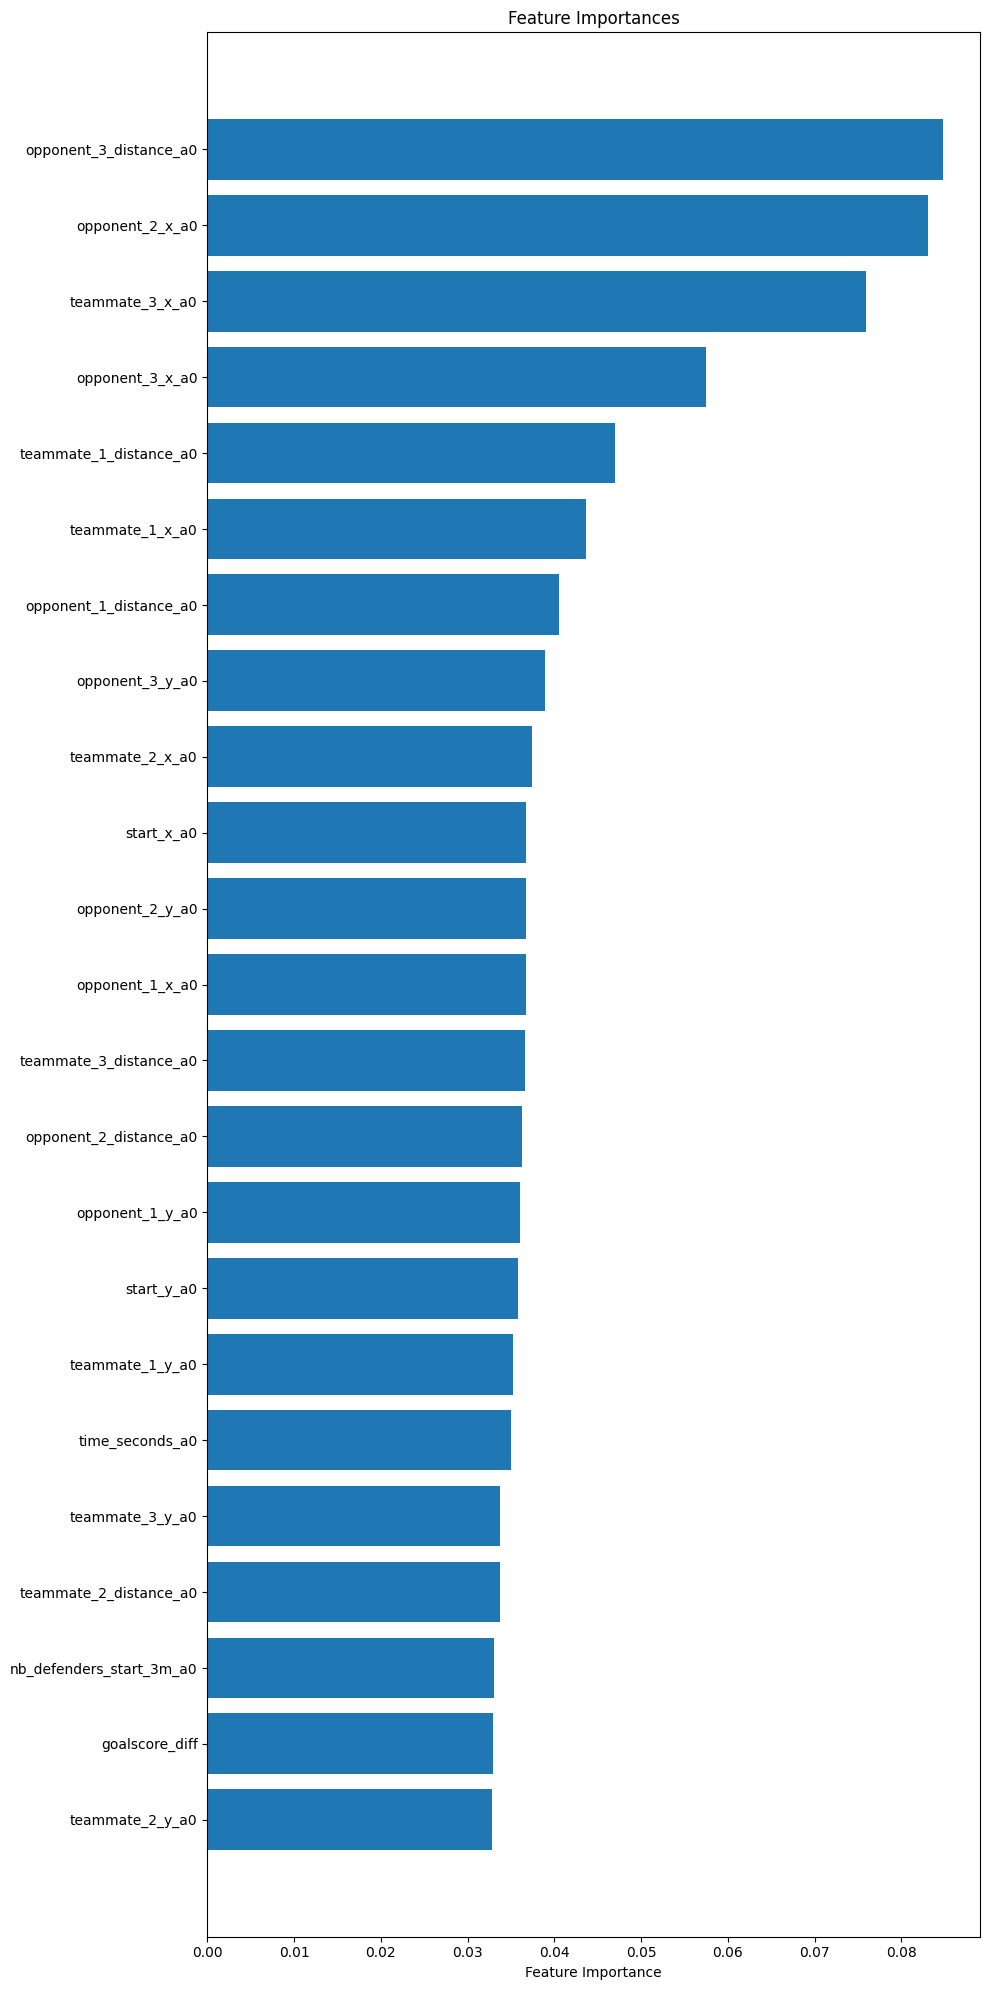

In [49]:
features = [col for _, cols in model.features.items() for col in cols]
importances = model.model.feature_importances_

# 컬럼 수에 따라 가변적인 시각화 크기 설정
num_features = len(features)
plt.figure(figsize=(max(10, num_features * 0.1), 20))  # 특징 수에 따라 증가


indices = np.argsort(importances) 
plt.barh(range(num_features), importances[indices], align='center')
plt.yticks(range(num_features), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')

plt.tight_layout()
plt.show()

In [50]:
game_id = 3895302

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895302,0,221b0c8d-6386-4ae8-bb4a-a1dc98742312,1,3.417,176,34870,52.0625,33.660,53.8125,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 12299, 'name': '...",None,0,None,pass,success,foot_right
1,3895302,1,77809242-1460-4395-8779-94a0cfc275b1,1,3.870,176,12299,53.8125,34.340,53.8125,...,176.0,From Kick Off,0,"{'carry': {'end_location': [59.0, 40.6]}}",None,0,None,dribble,success,foot
2,3895302,2,ff56e821-21e9-4cef-ba2a-7eb5eb3769c6,1,4.732,176,12299,53.8125,34.085,74.7250,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 31100, 'name': '...","[[90.44126933110154, 68.0], [67.695055809645, ...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
3,3895302,3,cf9088bc-7e59-4d57-8ac5-31658da858bb,1,6.728,176,31100,74.7250,36.295,74.7250,...,176.0,From Kick Off,0,"{'carry': {'end_location': [35.1, 43.7]}}","[[94.70003623525969, 68.0], [70.82236198763701...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
4,3895302,4,4464cb75-f45f-4508-8444-2560d1625d06,1,7.622,176,31100,74.7250,36.720,76.3875,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 51769, 'name': '...","[[96.23592025888192, 68.0], [71.95638033011264...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right


### Visualization

Skip action due to missing freeze frame


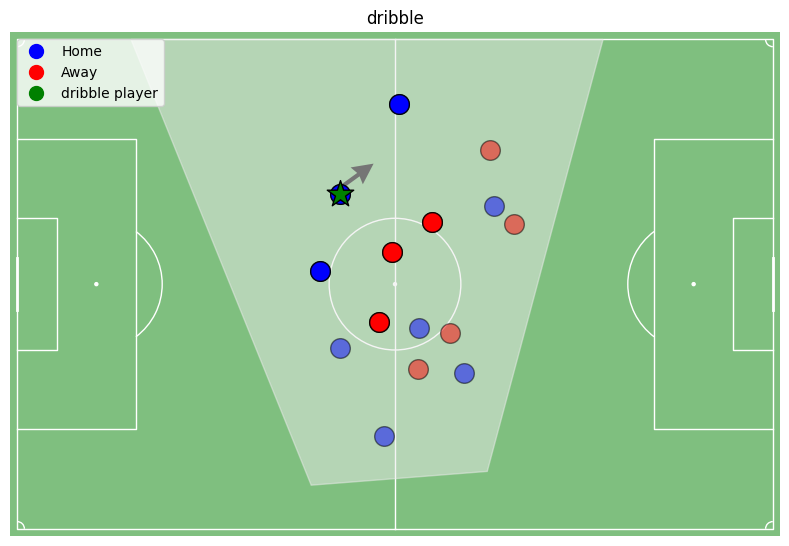

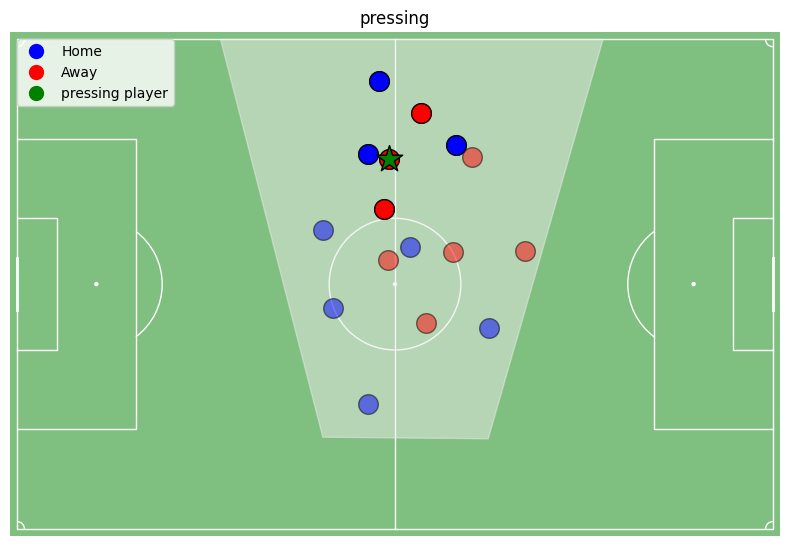

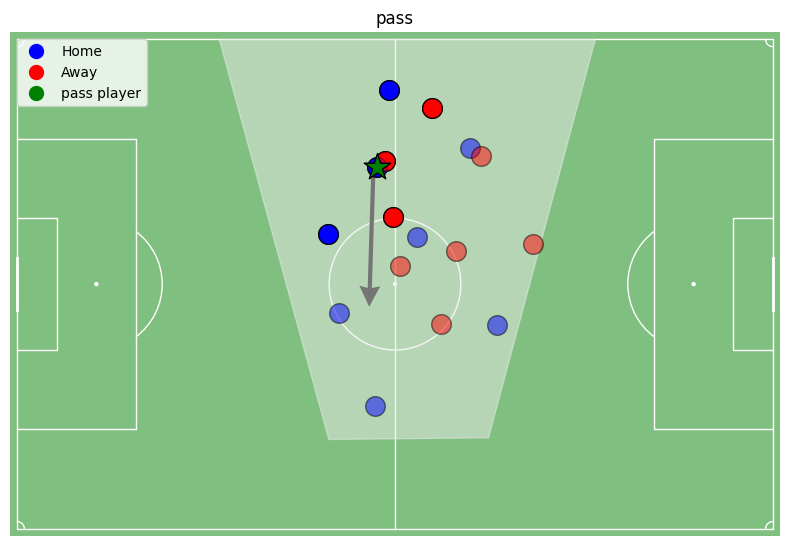

In [51]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)